## more methods

The previous method failed, can we try something else like
https://github.com/pupil-labs/pupil/blob/master/pupil_src/capture/pupil_detectors/canny_detector.py

or detect all contours, then apply a heuristic to catch the features (in previosion to use camshift to track them)...


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


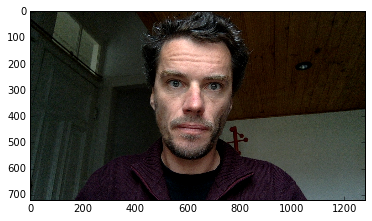

In [2]:
from LeCheapEyeTracker import LeCheapEyeTracker
cam = LeCheapEyeTracker()
frame = cam.grab()
frame = cam.grab()
cam.close()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [3]:
if len(cam.ctime) >0:
    plt.plot(np.diff(np.array(cam.ctime))*1000, '+')
    _ = plt.axis('tight')
    print ('FPS : ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))

## and now... move your eyes, not the head

we grab 42 frames. why 42? I recommend to not move the head (hold them in your hands) and to look at the led of your webcam. when it's lit, move your eyes evenly on the screen.

In [4]:
N_frame = 42
H, W, three = frame.shape
movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)
cam = LeCheapEyeTracker()
import time
time.sleep(1.)
img0 = cam.grab()
for i in range(N_frame):
    movie[:, :, :, i] = cam.grab()
    time.sleep(0.3)
    print(i)
img = cam.grab()
cam.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


(720, 1280, 3, 42) 0 255


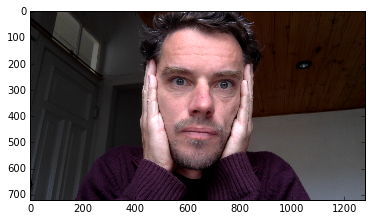

In [5]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))

2
2
271 122 109 109
2
108 116 101 101


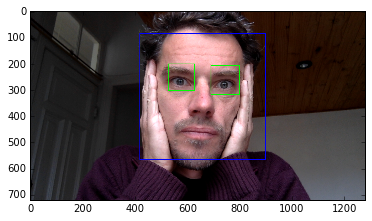

In [6]:
import cv2

face_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_eye.xml')
lefteye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_lefteye_2splits.xml')
righteye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_righteye_2splits.xml')

img_ = img0.copy()
out = img0.copy()
def get_just_one(image, cascade):
    # We set set minNeighbors=1 then increase it until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
    features, minNeighbors = [], 1
    while len(features) == 0 and minNeighbors<20:
        features = cascade.detectMultiScale(image, 1.1, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
        minNeighbors += 1
        print(minNeighbors)
    return features[0], minNeighbors

(x,y,w,h), minNeighbors = get_just_one(img_, face_cascade)

img_ = cv2.rectangle(img_, (x,y), (x+w,y+h), (255,0,0), 2)
roi_color = img_[y:y+h, x:x+w]
out_color = out[y:y+h, x:x+w]

(lex, ley, lew, leh), minNeighbors = get_just_one(roi_color, lefteye_cascade)
cv2.rectangle(roi_color, (lex, ley), (lex+lew, ley+leh), (0,255,0), 2)
left_eye = out_color[ley:ley+leh, lex:lex+lew]
print(lex, ley, lew, leh)

(rex, rey, rew, reh), minNeighbors = get_just_one(roi_color, righteye_cascade)
cv2.rectangle(roi_color, (rex, rey), (rex+rew, rey+reh), (0,255,0), 2)
right_eye = out_color[rey:rey+reh, rex:rex+rew]
print(rex, rey, rew, reh)


plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))

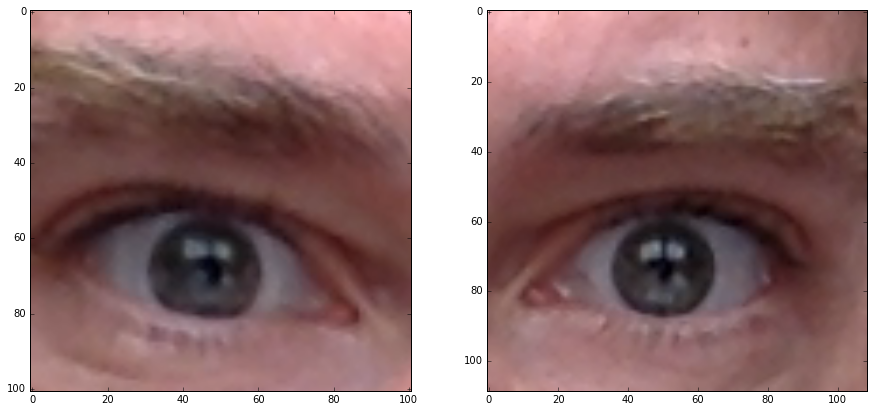

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([right_eye, left_eye]):
    axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))


##  segmenting using dynamics

- the eyebrow on upper quarter 
- the skin is all around
- the reflection is white and small
- the iris is round, darker


In [8]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
#print (flags)

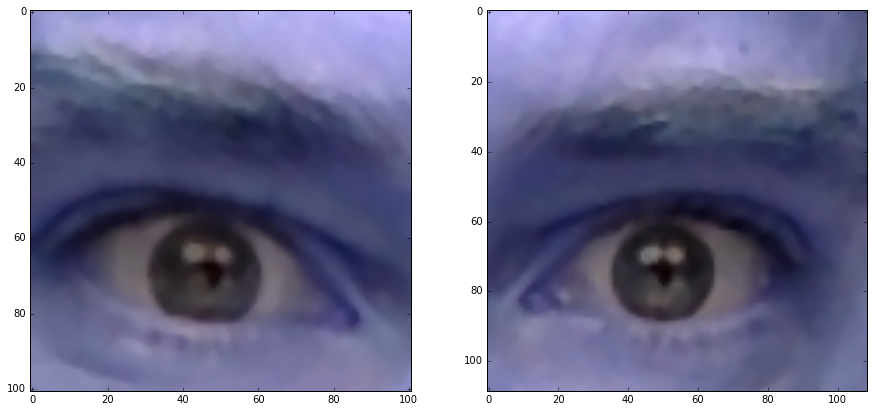

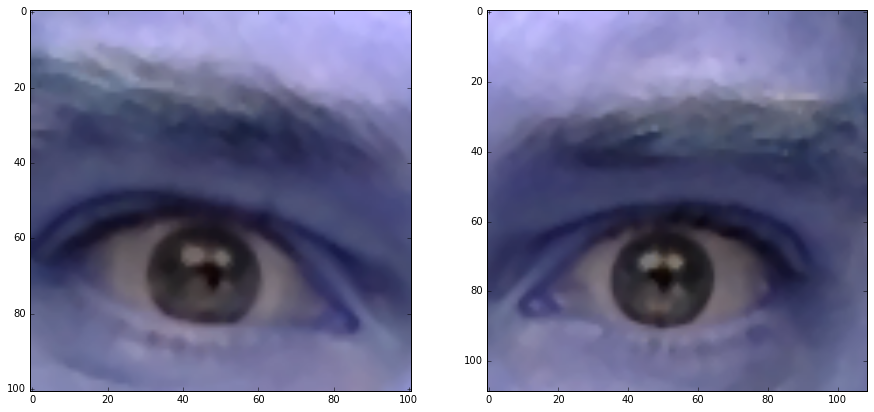

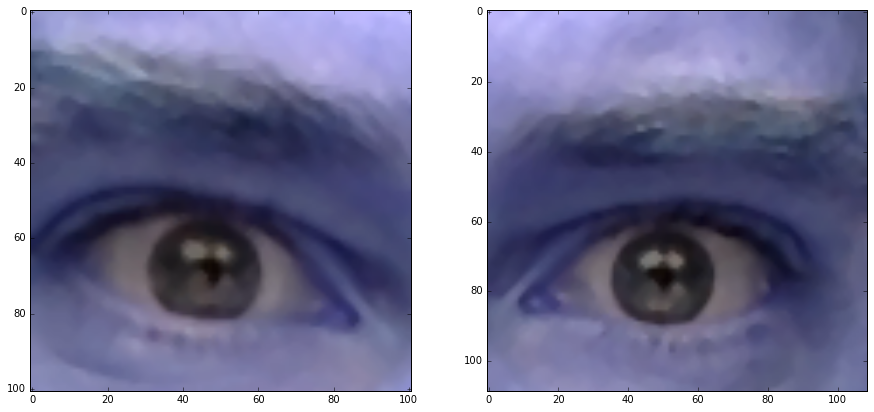

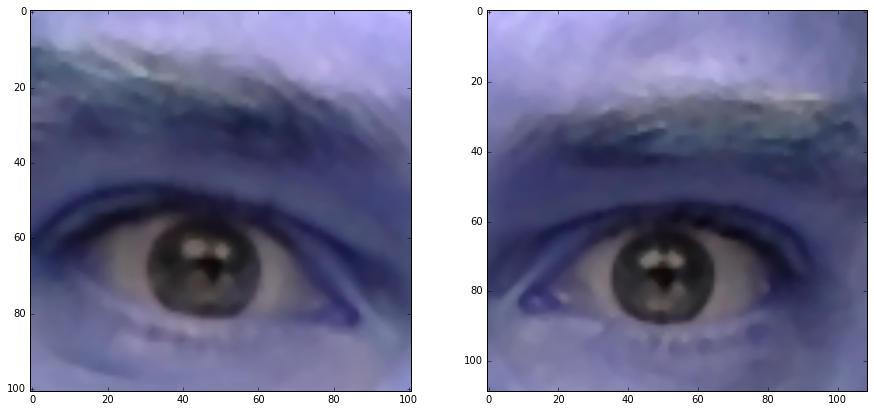

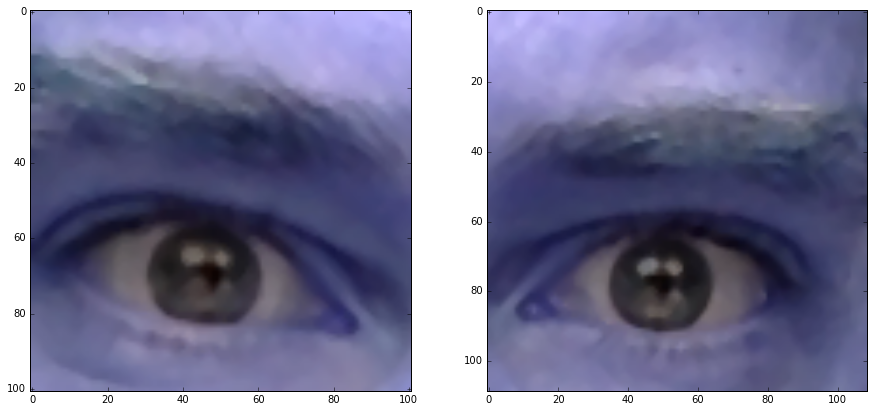

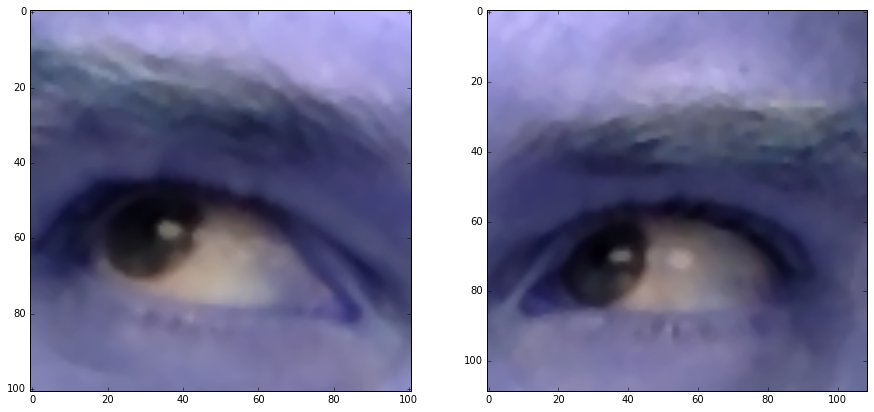

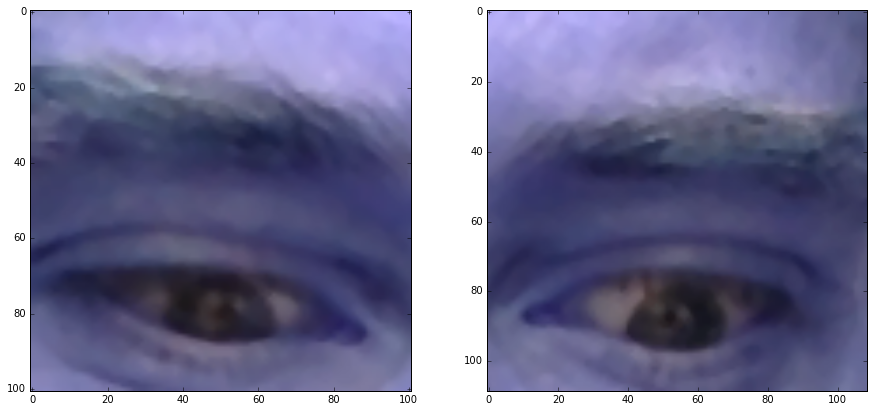

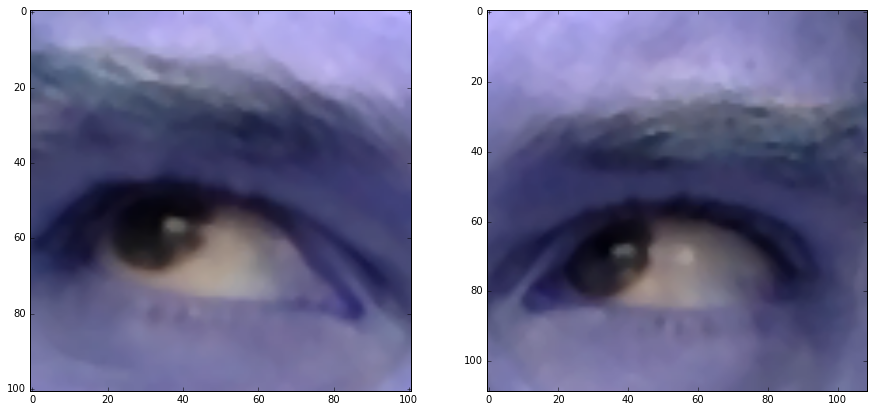

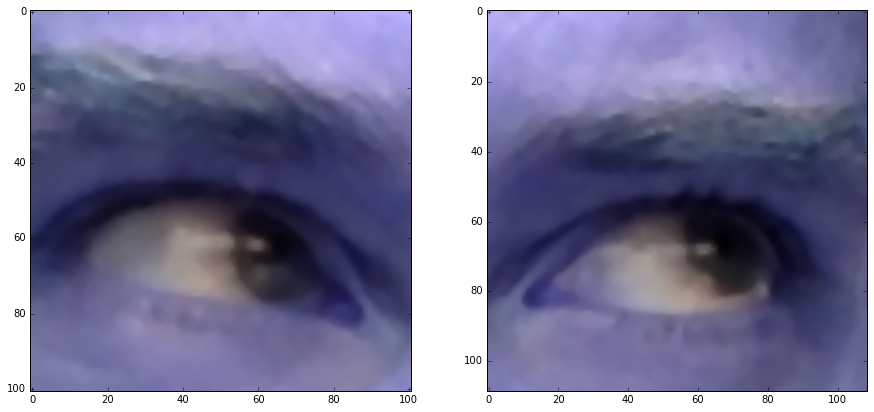

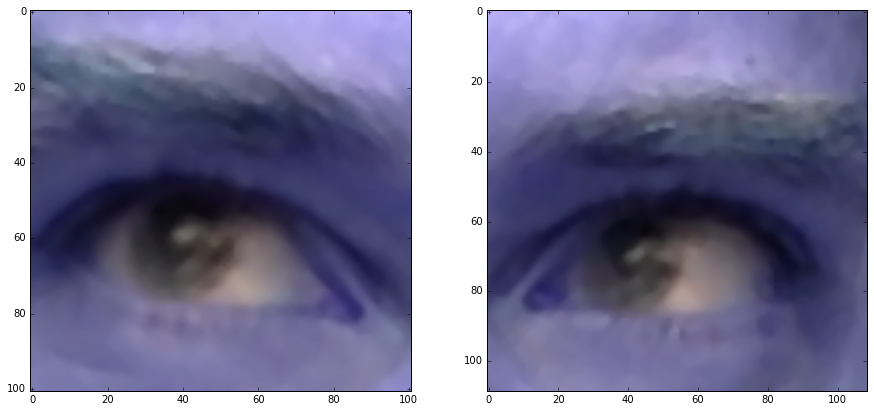

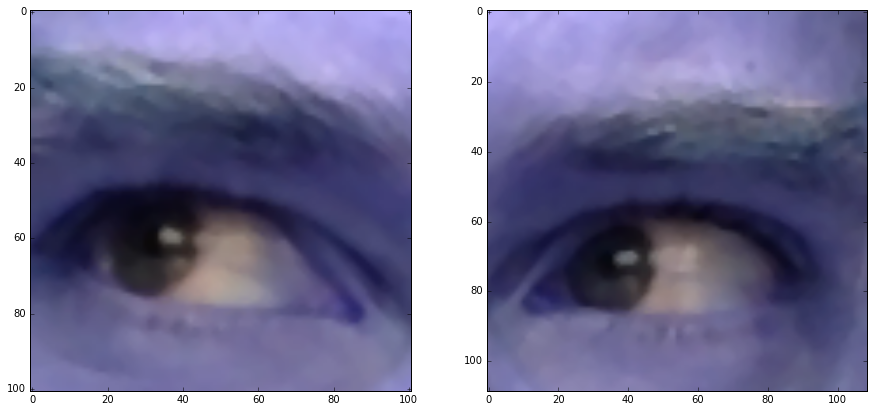

In [9]:
left_eye_movie = np.zeros((leh, lew, 3, N_frame), dtype=np.uint8)
right_eye_movie = np.zeros((reh, rew, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    out_color = movie[y:y+h, x:x+w, :, i]
    out_color = cv2.medianBlur(out_color, 3)
    #out_color = cv2.cvtColor(out_color, cv2.COLOR_BGR2HSV)
    left_eye_movie[:, :, :, i] = out_color[ley:ley+leh, lex:lex+lew]
    right_eye_movie[:, :, :, i] = out_color[rey:rey+reh, rex:rex+rew]
    if i % 4 ==0:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
        for i_, eye in enumerate([right_eye_movie[:, :, :, i], left_eye_movie[:, :, :, i]]):
            axs[i_].imshow(eye)

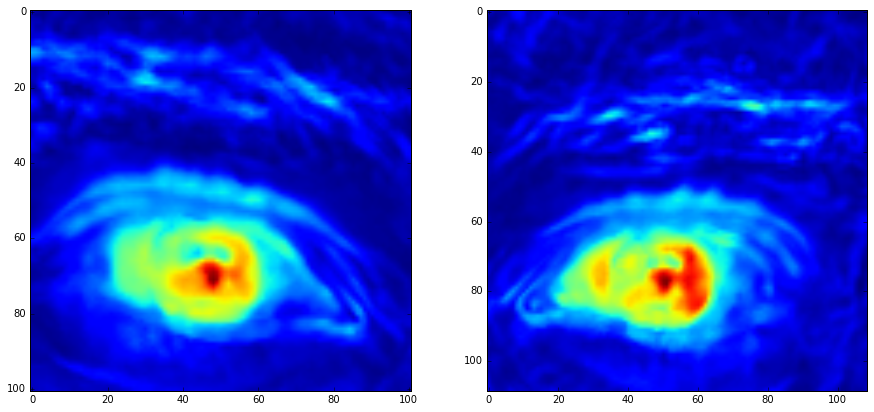

In [10]:
# deviation in the average (gray image)
std_left_eye = left_eye_movie.mean(axis=-2).std(axis=-1)
std_right_eye = right_eye_movie.mean(axis=-2).std(axis=-1)
# better : average of the deviation in aeach channel
std_left_eye = left_eye_movie.std(axis=-1).mean(axis=-1)
std_right_eye = right_eye_movie.std(axis=-1).mean(axis=-1)


fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    axs[i].imshow(eye)

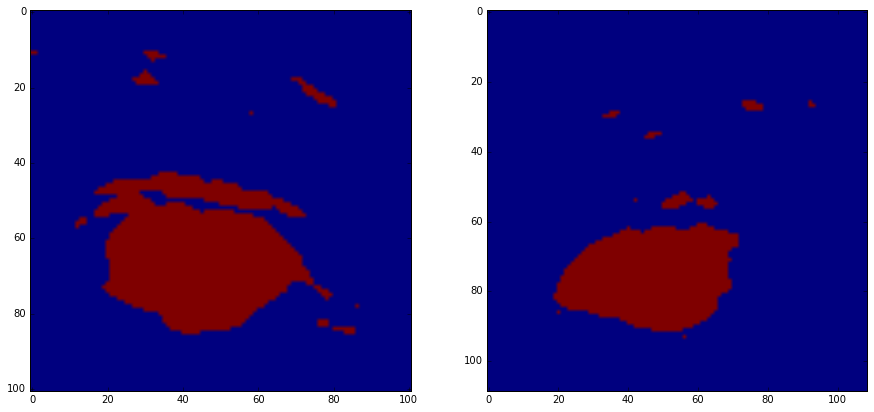

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    eye /= eye.max()
    eye *= 255
    ret_skin, skin_mask = cv2.threshold(eye.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    axs[i].imshow(skin_mask)

Final touch: erode and dilate until we only one connected component, see https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

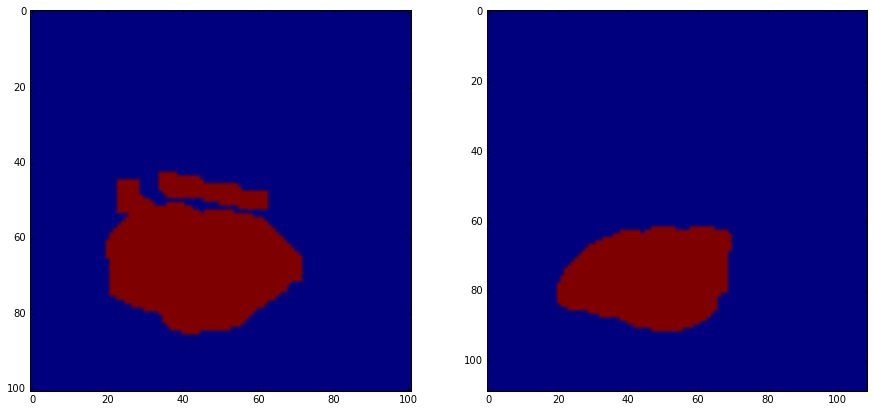

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    eye /= eye.max()
    eye *= 255
    ret_skin, skin_mask = cv2.threshold(eye.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
    axs[i].imshow(skin_mask)


### histogram backprojection

Now that we have a nice mask, we may grab (only) the interesting part: the eye and pupil... We will use the method described in https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/py_histogram_backprojection.html



In [13]:
left_eye_movie = np.zeros((leh, lew, 3, N_frame), dtype=np.uint8)
right_eye_movie = np.zeros((reh, rew, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    out_color = movie[y:y+h, x:x+w, :, i]
    #out_color = cv2.medianBlur(out_color, 7)
    #out_color = cv2.cvtColor(out_color, cv2.COLOR_BGR2HSV)
    left_eye_movie[:, :, :, i] = out_color[ley:ley+leh, lex:lex+lew]
    right_eye_movie[:, :, :, i] = out_color[rey:rey+reh, rex:rex+rew]


0.0 255.0 <class 'numpy.ndarray'>
0 255 <class 'numpy.ndarray'>
0 255 (101, 101, 3) <class 'numpy.ndarray'>
0.0 255.0 (101, 101, 3) <class 'numpy.ndarray'>
0.0 255.0 <class 'numpy.ndarray'>
0 255 <class 'numpy.ndarray'>
0 255 (109, 109, 3) <class 'numpy.ndarray'>
0.0 255.0 (109, 109, 3) <class 'numpy.ndarray'>


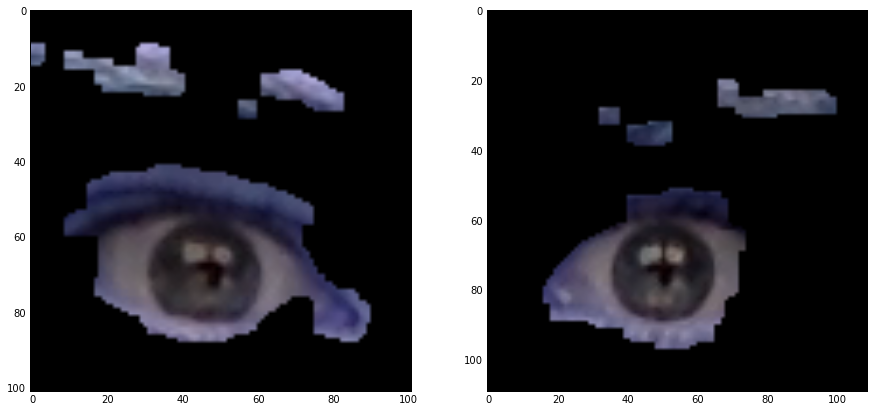

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye_movie in enumerate([right_eye_movie, left_eye_movie]):
    #print(eye_movie.min(), eye_movie.max(), type(eye_movie))
    eye_movie = eye_movie.astype(np.float)
    std_eye = eye_movie.std(axis=-1).mean(axis=-1)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye /= std_eye.max()
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye *= 255
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye = std_eye.astype(np.uint8)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    ret_skin, skin_mask = cv2.threshold(std_eye, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((5, 5))
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   
    #print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # calculating object histogram
    roihist = cv2.calcHist([std_eye], [0], skin_mask, [256], [0,256])
    #print(roihist.min(), roihist.max(), type(roihist))

    # normalize histogram and apply backprojection
    cv2.normalize(roihist, roihist, 0, 255, cv2.NORM_MINMAX)
    print(roihist.min(), roihist.max(), type(roihist))
    skin_mask = cv2.calcBackProject([std_eye], [0,1], roihist, [0, 256], 1)
    print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # Now convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    cv2.filter2D(skin_mask, -1, disc, skin_mask)
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   

    # threshold and binary AND
    ret, skin_mask = cv2.threshold(skin_mask, 50, 255, 0)
    skin_mask = cv2.merge((skin_mask,skin_mask,skin_mask))
    print(skin_mask.min(), skin_mask.max(), skin_mask.shape, type(skin_mask))
    print(eye_movie[:, :, :, 0].min(), eye_movie[:, :, :, 0].max(), eye_movie[:, :, :, 0].shape, type(eye_movie[:, :, :, 0]))
    eye = cv2.bitwise_and(eye_movie[:, :, :, 0].astype(np.uint8), skin_mask)

    axs[i].imshow(eye)
    

A simpler method:

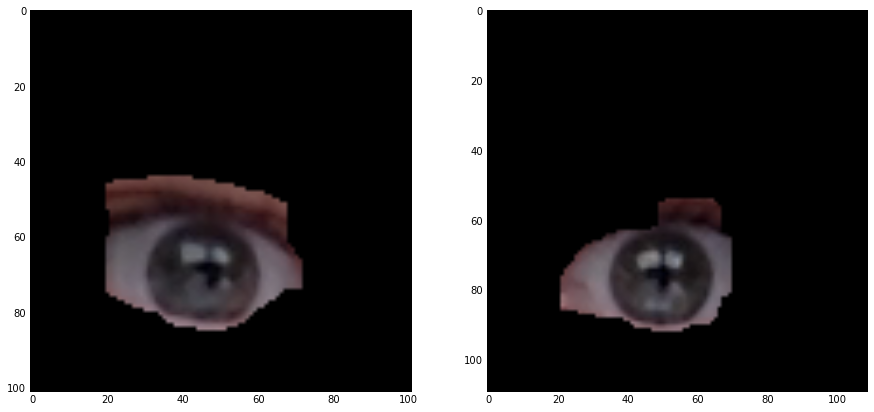

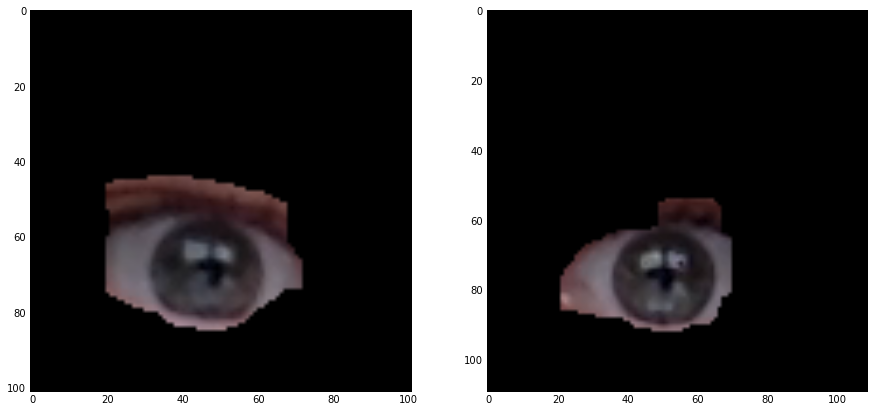

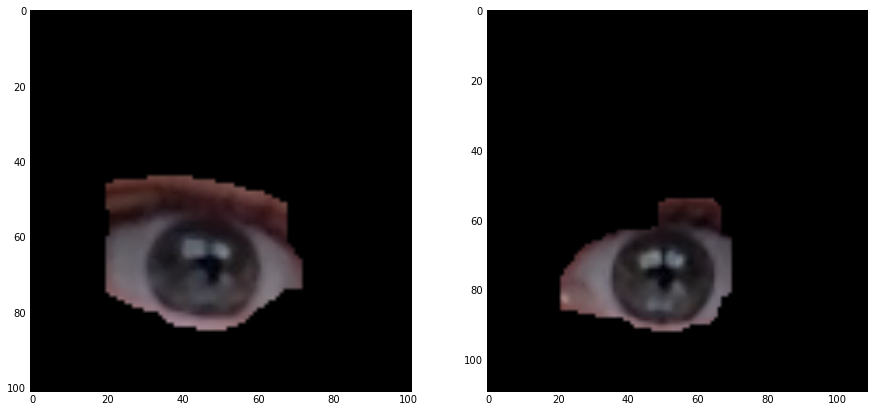

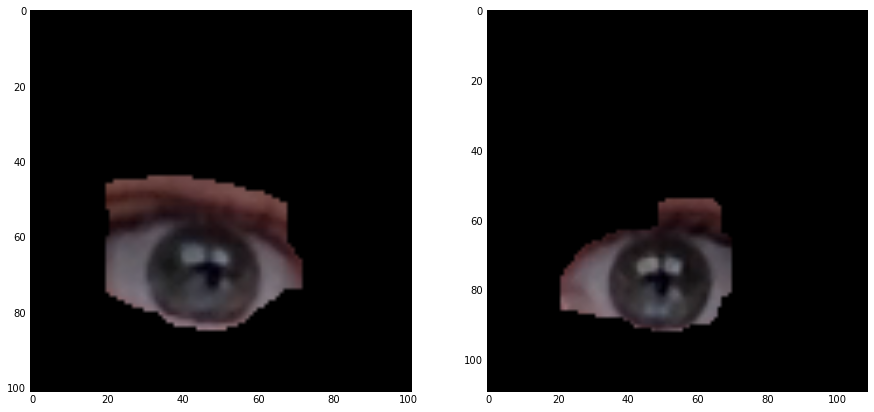

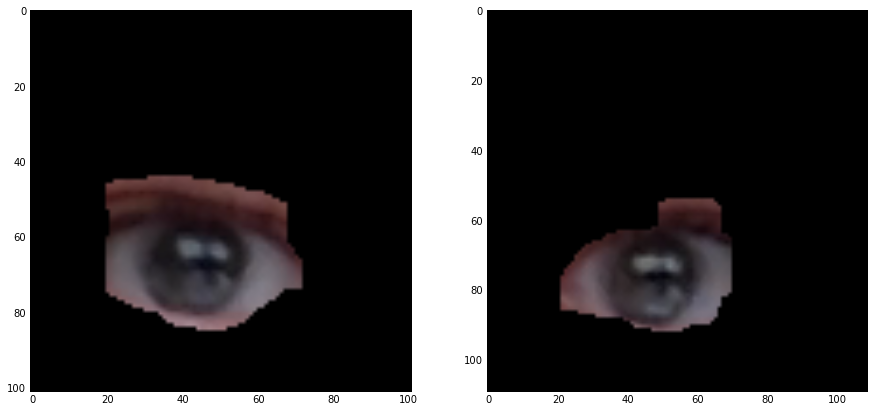

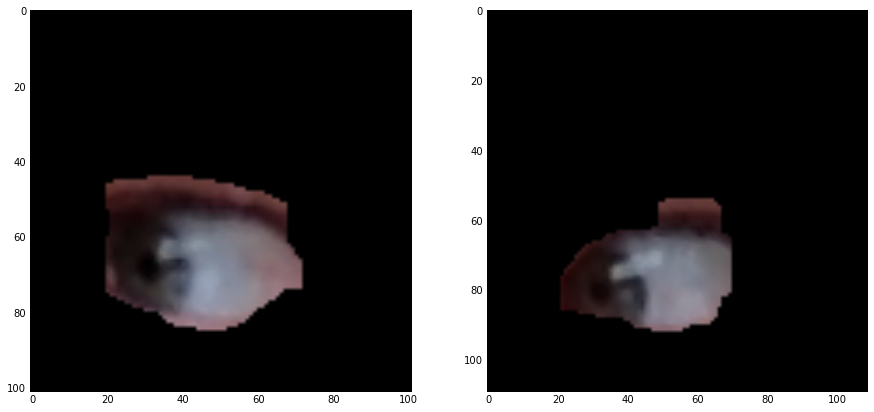

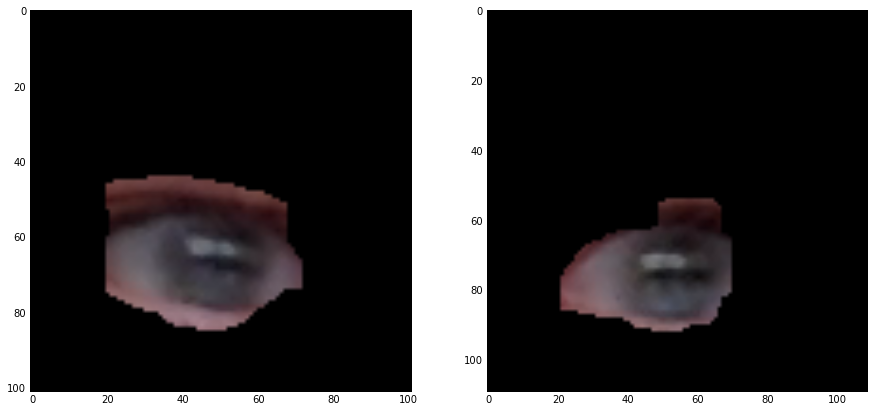

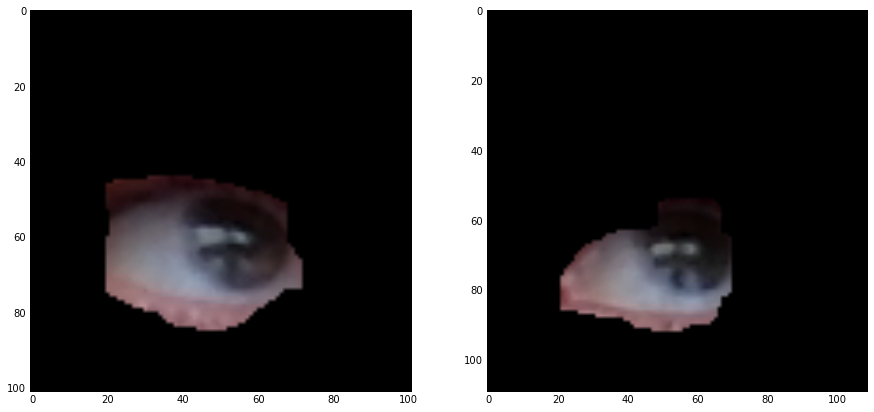

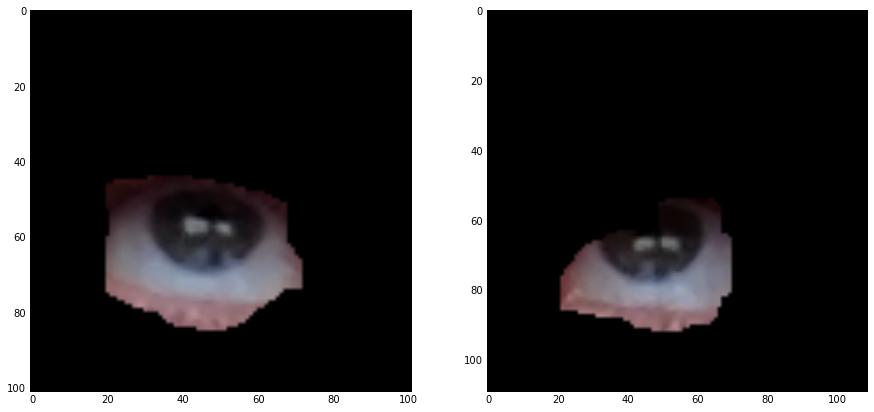

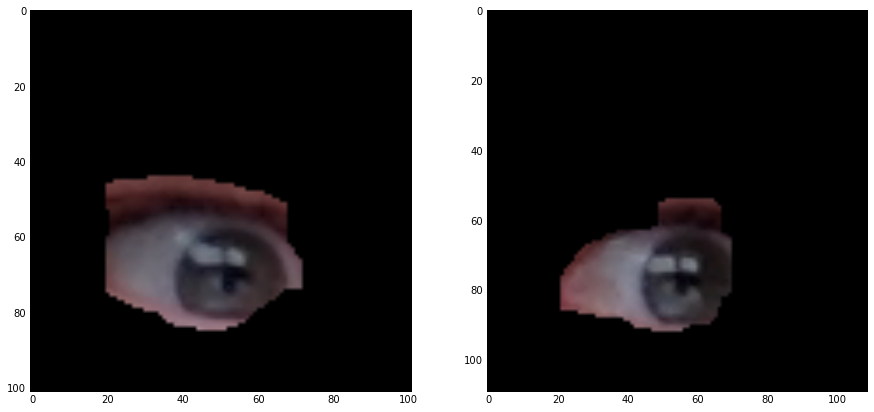

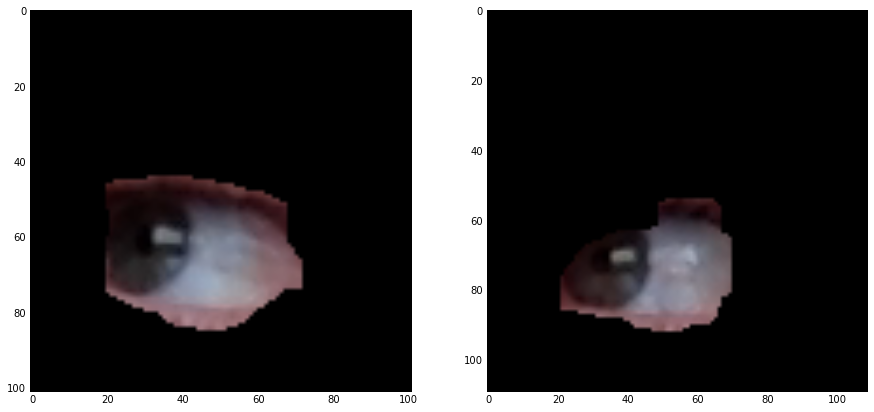

In [15]:
masks = []

for i, eye_movie in enumerate([right_eye_movie, left_eye_movie]):
    eye_movie_b = np.zeros_like(eye_movie)
    for i in range(N_frame):
        eye_movie_b[:, :, :, i] = cv2.medianBlur(eye_movie[:, :, :, i], 7)

    #print(eye_movie.min(), eye_movie.max(), type(eye_movie))
    eye_movie_b = eye_movie_b.astype(np.float)
    std_eye = eye_movie_b.std(axis=-1).mean(axis=-1)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye /= std_eye.max()
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye *= 255
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye = std_eye.astype(np.uint8)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    ret_skin, skin_mask = cv2.threshold(std_eye, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((7, 7))
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
    #print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # threshold and binary AND
    skin_mask = cv2.merge((skin_mask,skin_mask,skin_mask))
    #print(skin_mask.min(), skin_mask.max(), skin_mask.shape, type(skin_mask))
    masks.append(skin_mask)

for i_t in range(N_frame):
    if i_t % 4 ==0: fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
    for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
        eye = cv2.bitwise_and(eye_movie[:, :, :, i_t].astype(np.uint8), skin_mask)
        if i_t % 4 ==0: axs[i].imshow(eye)
        axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))

## more methods?

idea: detect all contours, then apply a heuristic to catch the features

In [17]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
print (M)
skin_mask = cv2.drawContours(skin_mask, contours, -1, (0,255,0), 3)
plt.imshow(skin_mask)


error: /tmp/opencv320151022-12569-uj2d50/opencv-3.0.0/modules/imgproc/src/contours.cpp:198: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours


In [18]:
ellipse = cv2.fitEllipse(cnt)
skin_mask = cv2.ellipse(skin_mask, ellipse,(0,255,0), 2)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

NameError: name 'cnt' is not defined

In [19]:
img = eyelist[0].copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(hsv[:, :, i]*skin_mask)


NameError: name 'eyelist' is not defined

In [20]:
value = hsv[:, :, 2].copy()
hist = cv2.calcHist([value], [0], skin_mask * (255 - reflection_mask), [256], [0, 256])
ret, iris_mask = cv2.threshold(value, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
iris_mask = cv2.bitwise_and(iris_mask, iris_mask, mask=skin_mask * (255 - reflection_mask))
plt.imshow(iris_mask)

NameError: name 'hsv' is not defined

In [21]:
iris = iris_mask + skin_mask
iris = cv2.erode(iris, kernel, iterations = 1)
plt.imshow(iris)
plt.colorbar()

NameError: name 'iris_mask' is not defined

In [22]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

error: /tmp/opencv320151022-12569-uj2d50/opencv-3.0.0/modules/imgproc/src/contours.cpp:198: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours


## more methods : use canny

https://github.com/pupil-labs/pupil/blob/master/pupil_src/capture/pupil_detectors/canny_detector.py


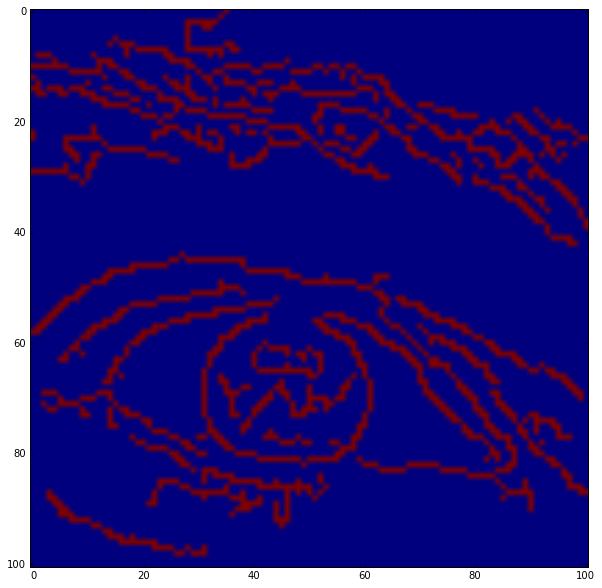

In [23]:
image = right_eye.copy()

#ret,thresh = cv2.threshold(img,127,255,0)
edges = cv2.Canny(image, 50, 120)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(edges)

70.18376564979553 9.5 518.5011537668862
144.1248904466629 16.5 1258.9081240159142
26.97056221961975 2.0 363.70561322119016
19.313708305358887 1.0 373.01932850448884
83.154327750206 12.5 553.1713778870943
96.32590079307556 4.5 2061.9287030216524
73.49747383594513 12.5 432.1502928212351
23.313708305358887 3.0 181.17633164912
63.69848430156708 3.5 1159.284829233425
38.87005698680878 7.5 201.4508440210349
278.73506236076355 38.0 2044.5588155068092
83.1543276309967 14.5 476.871876121596
80.76955187320709 7.0 931.9600728283846
83.0121922492981 7.5 918.8032082712568
328.0487691164017 29.0 3710.8963765098692
22.14213538169861 1.0 490.2741592614694
47.69848442077637 7.5 303.35272213853943
32.14213538169861 2.0 516.5584334477207
8.828427076339722 1.0 77.94112464224833
3.414213538169861 0.5 23.31370816844472
55.21320295333862 3.5 870.9993658190173
37.69848418235779 4.5 315.81682436610674
23.798989295959473 1.0 566.3918915091936
21.656854152679443 1.0 469.01933179042885
86.9116872549057 7.0 1079.0

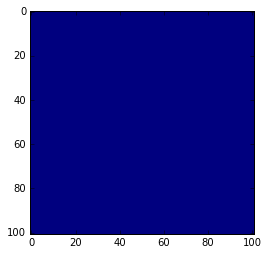

In [24]:
image_, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    rect = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    if area > 0:
        print (perimeter, area, perimeter**2/area)
    #M = cv2.moments(cnt)
    #print (M)
edges = cv2.drawContours(edges, contours, -1, (0,255,0), 3)
plt.imshow(edges)

In [25]:
image = eyelist[0].copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, cv2.CV_64F)*1.
image - image.mean()
image /= (image.max() - image.min())
print(image.max(), image.min())
#image = cv2.equalizeHist(image)
kernel = np.ones((3,3))/5
N = image.shape[0]//8
min_DOG, max_DOG = np.zeros(N), np.zeros(N)
for i in range(N):
    #
    image = cv2.filter2D(image, -1, kernel)
    DOG = cv2.Laplacian(image, cv2.CV_64F)#, None, 2*i+1)
    min_DOG[i], max_DOG[i] = DOG.min(), DOG.max()

fig = plt.figure(figsize=(15, 5))

for i, _DOG in enumerate([min_DOG, max_DOG]): 
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(range(N), _DOG)

NameError: name 'eyelist' is not defined

In [26]:
cv2.SimpleBlobDetector?

Object `cv2.SimpleBlobDetector` not found.


In [27]:
cv2.SimpleBlobDetector_create?